# Dataset exploration

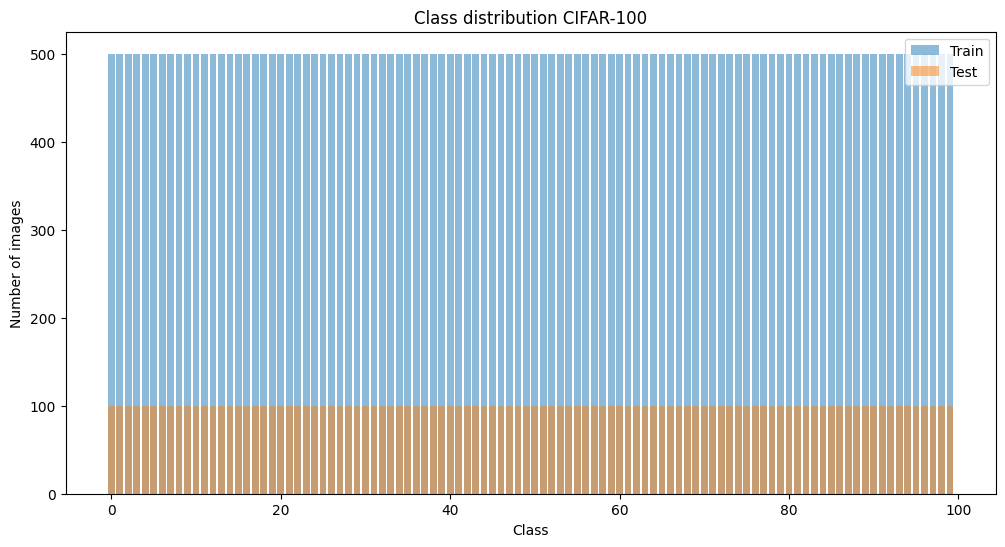

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

unique_train, counts_train = np.unique(y_train, return_counts=True)
class_distribution_train = dict(zip(unique_train, counts_train))

unique_test, counts_test = np.unique(y_test, return_counts=True)
class_distribution_test = dict(zip(unique_test, counts_test))

plt.figure(figsize=(12, 6))
plt.bar(class_distribution_train.keys(), class_distribution_train.values(), alpha=0.5, label="Train")
plt.bar(class_distribution_test.keys(), class_distribution_test.values(), alpha=0.5, label="Test")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.title("Class distribution CIFAR-100")
plt.legend()
plt.show()

## Showing 5 images for each class

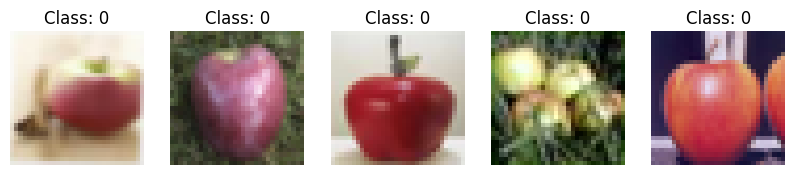

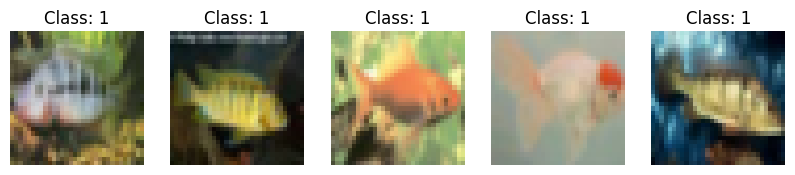

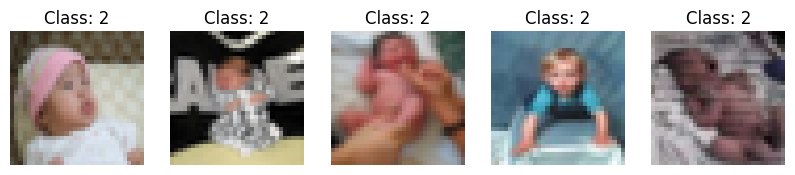

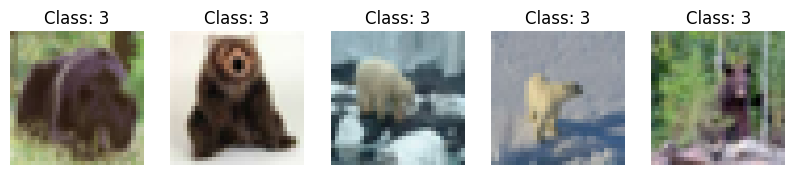

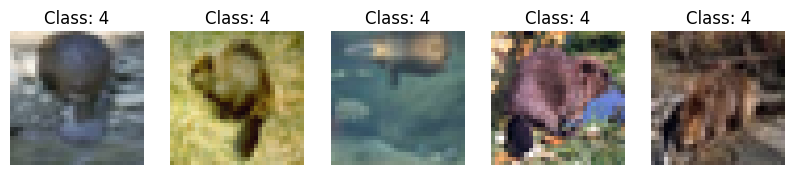

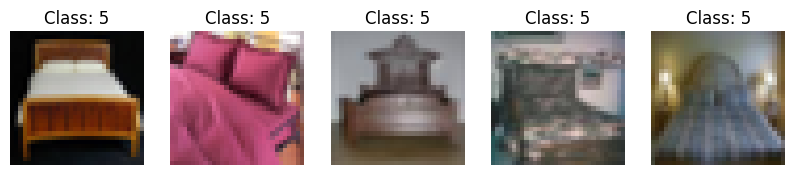

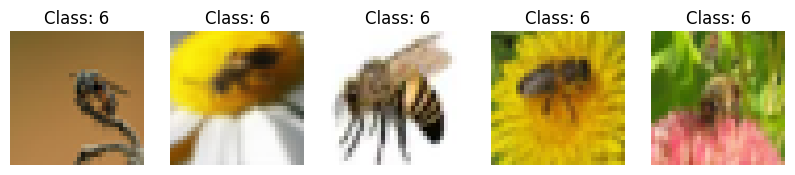

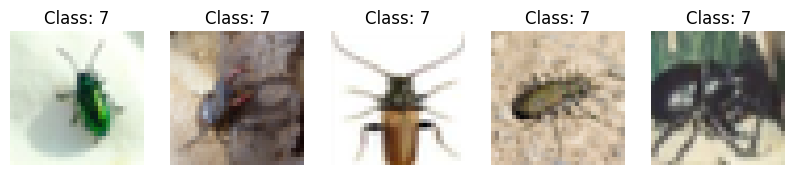

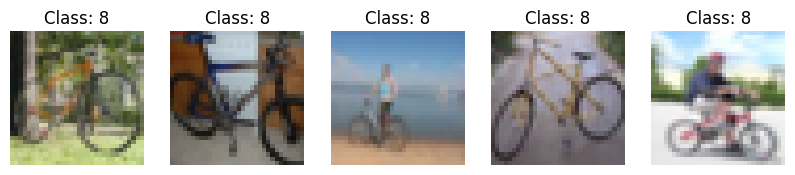

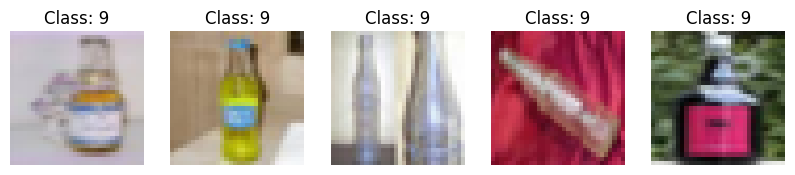

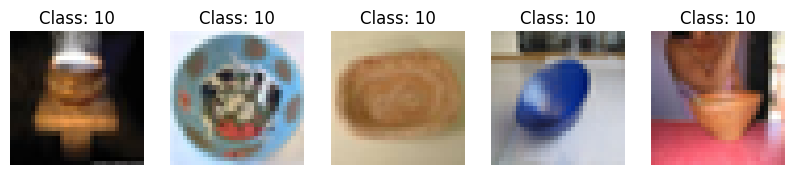

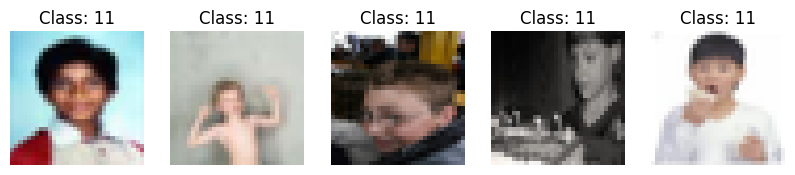

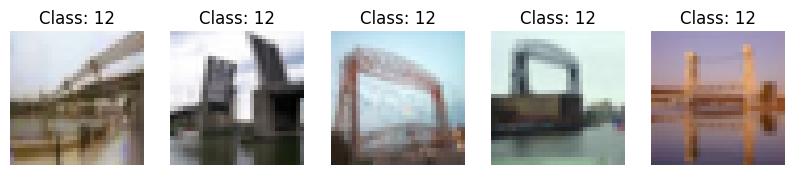

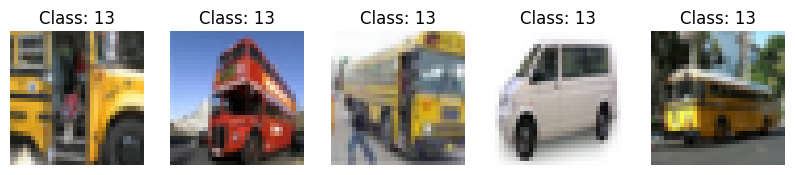

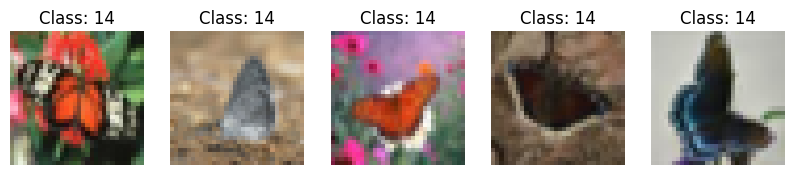

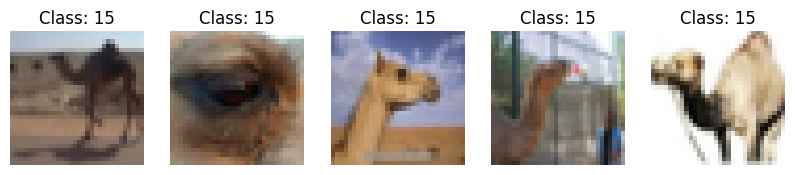

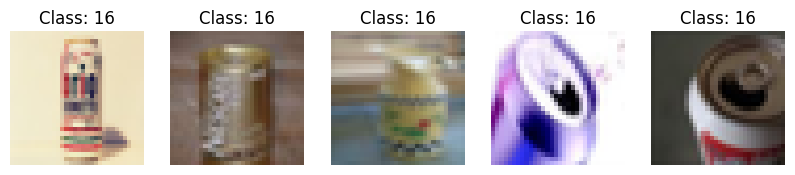

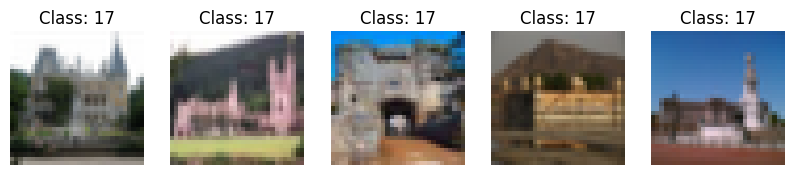

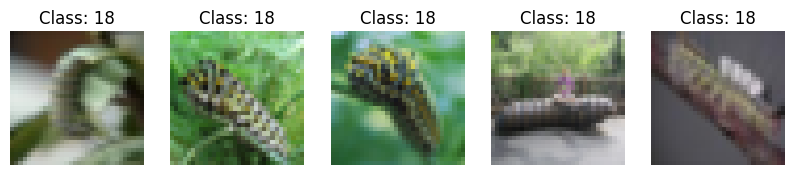

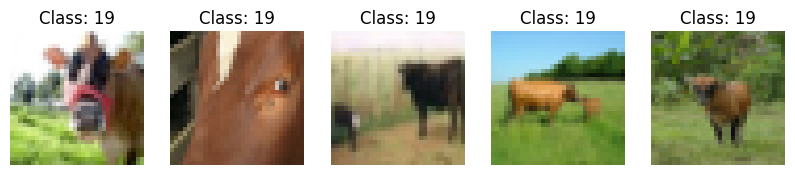

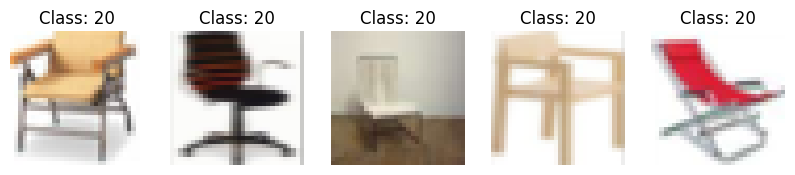

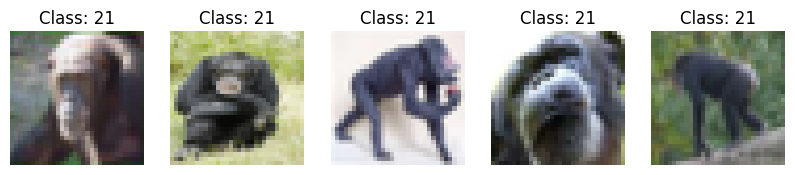

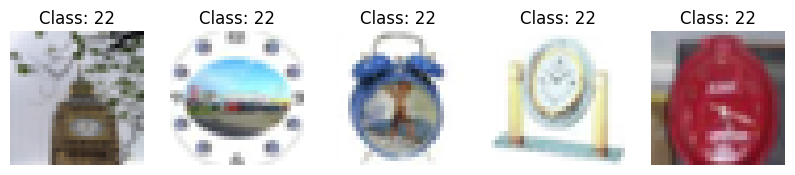

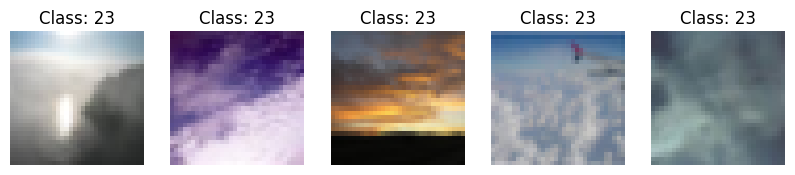

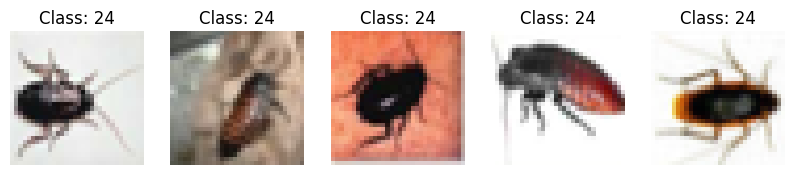

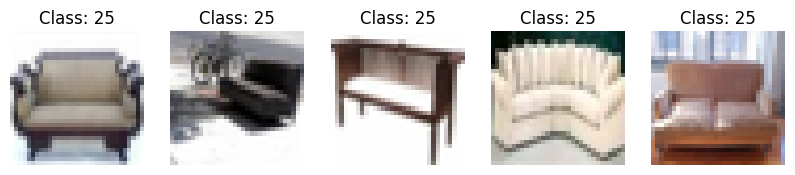

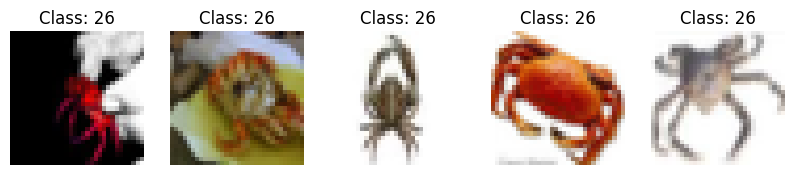

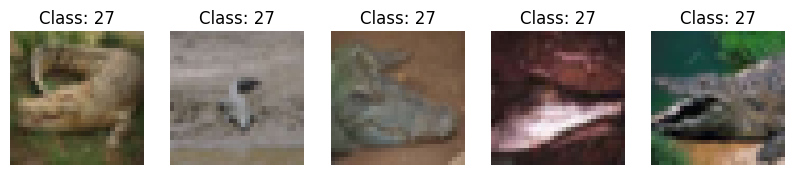

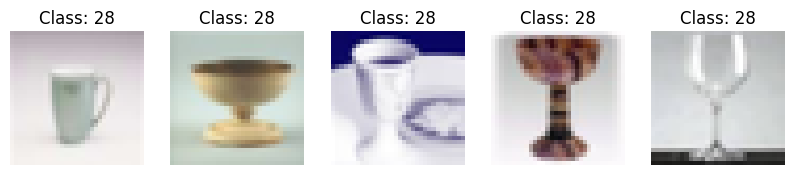

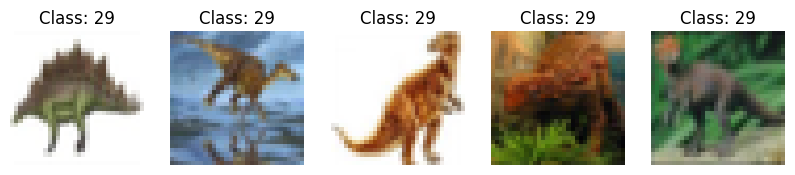

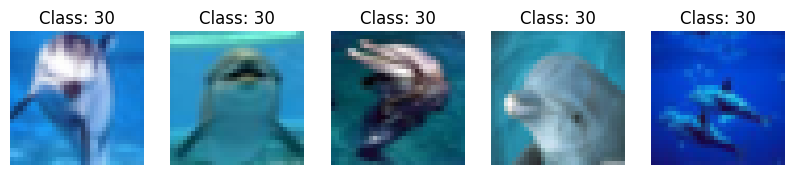

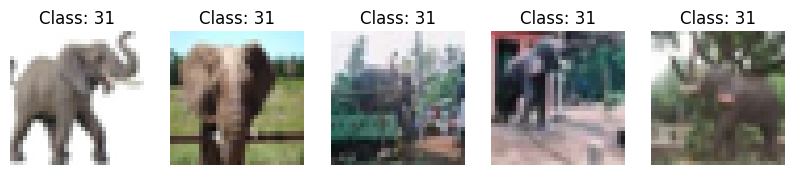

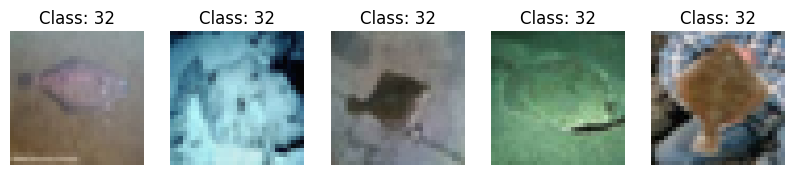

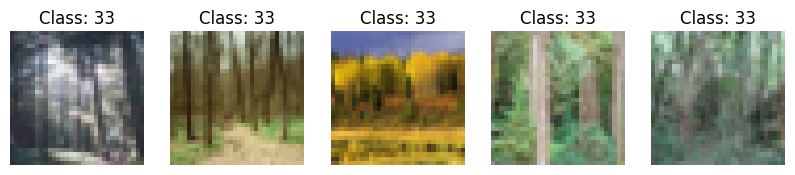

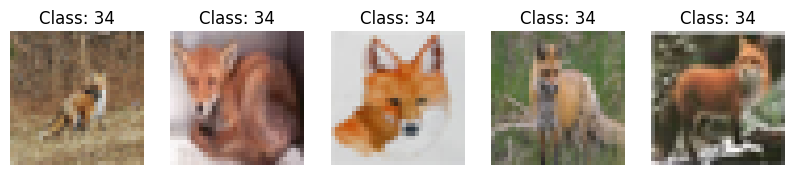

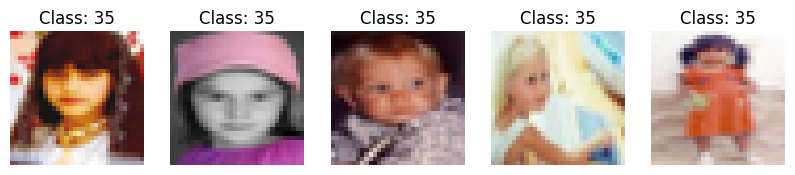

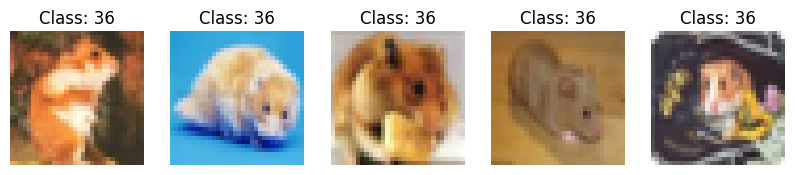

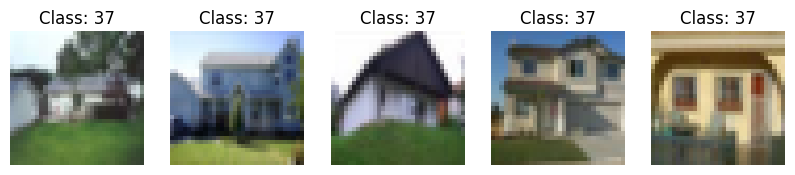

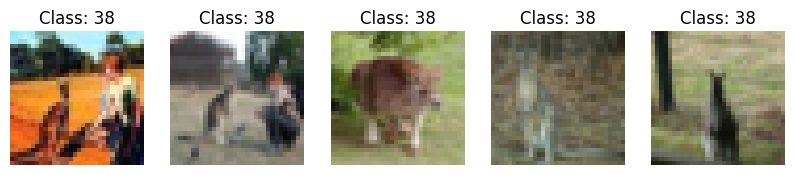

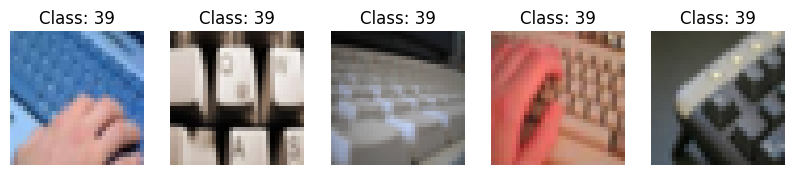

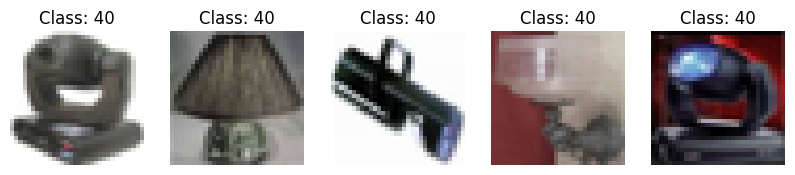

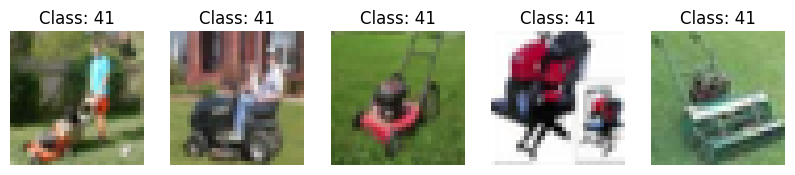

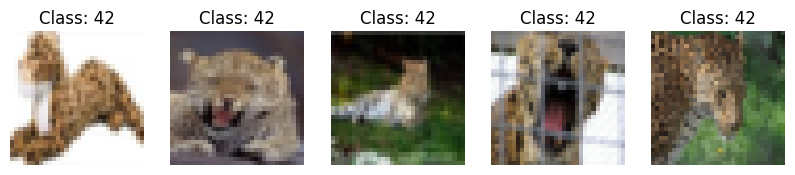

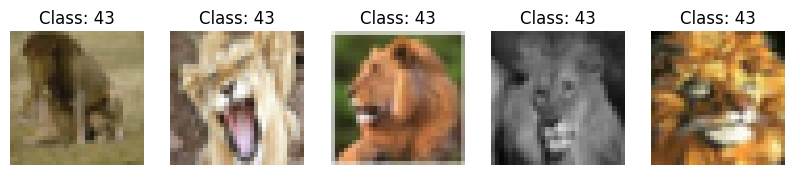

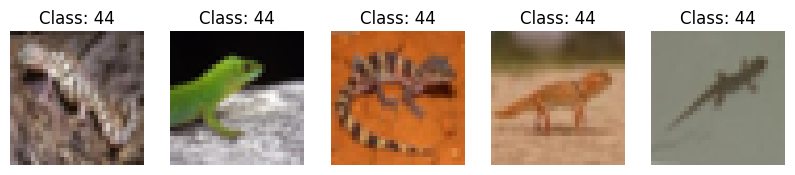

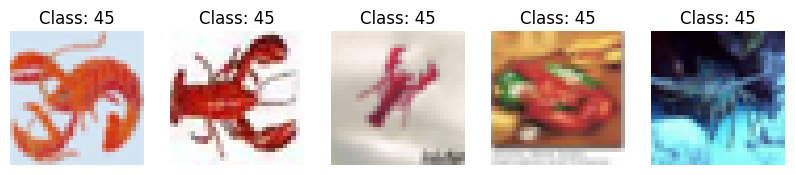

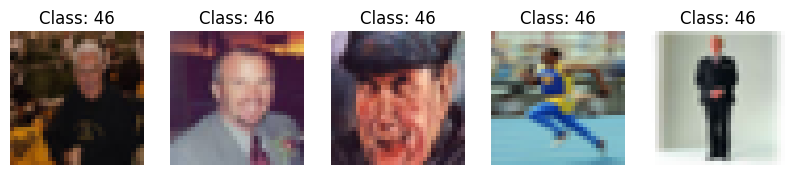

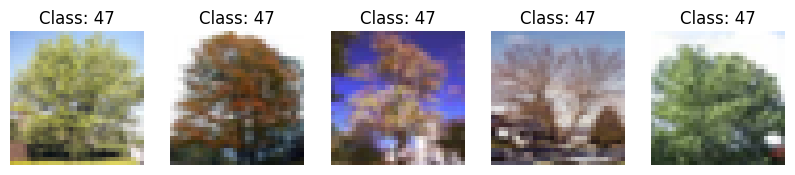

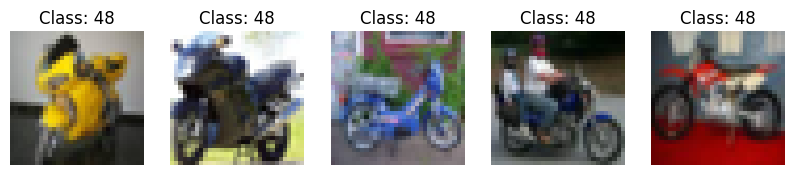

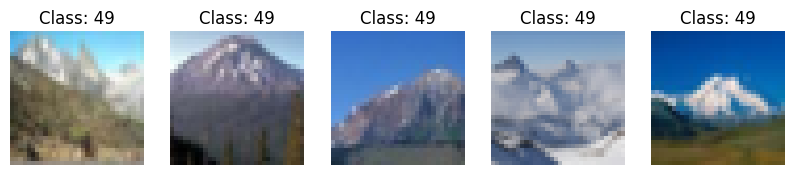

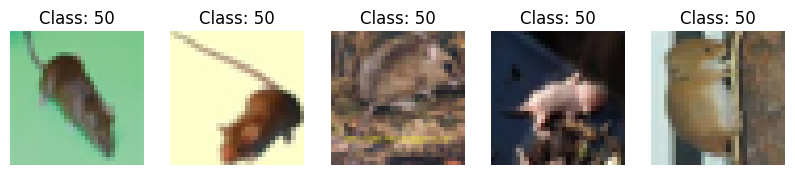

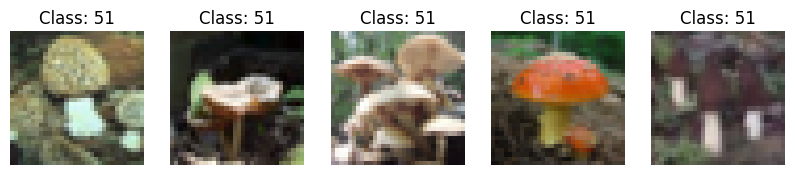

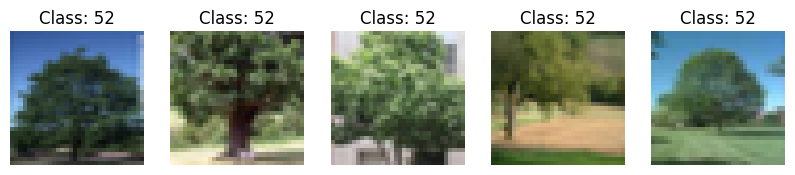

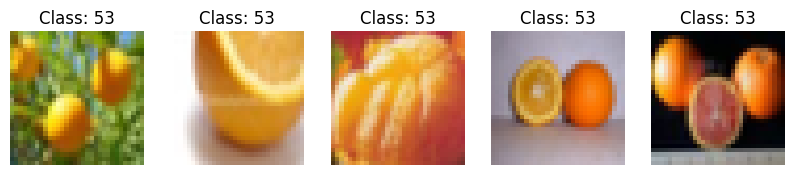

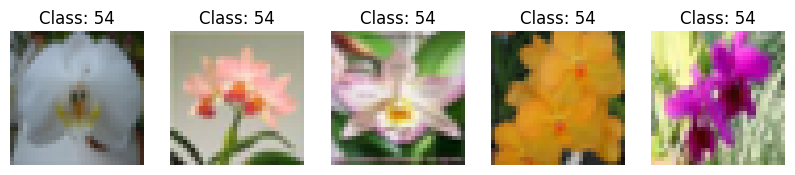

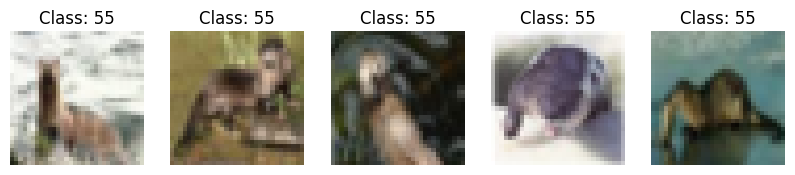

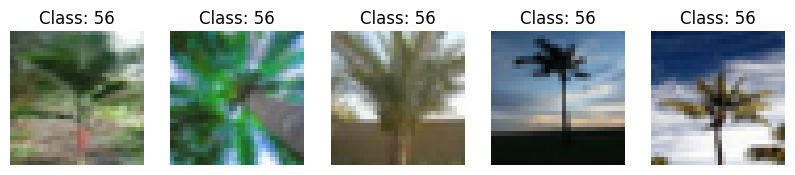

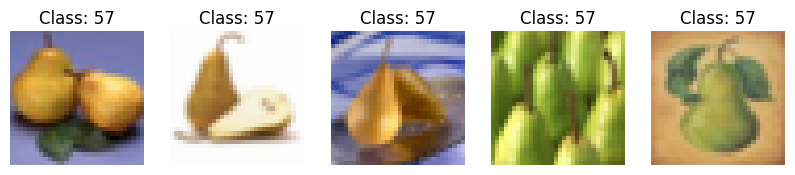

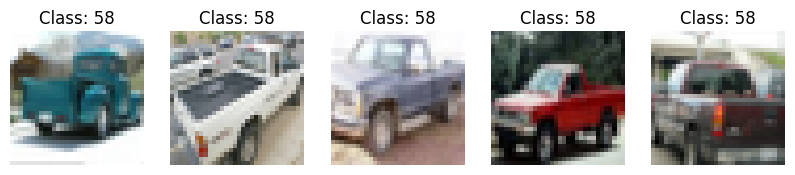

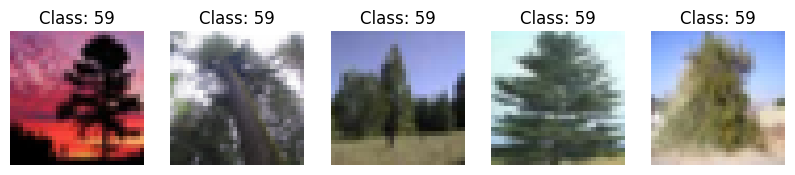

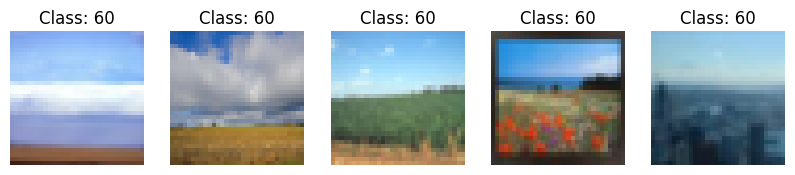

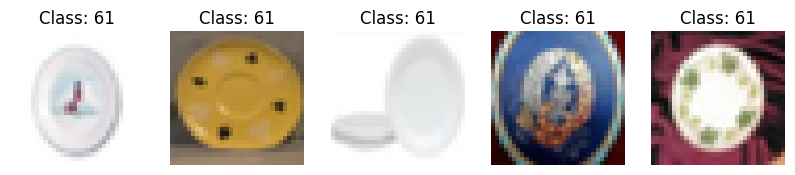

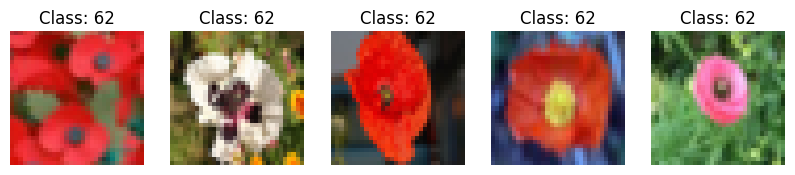

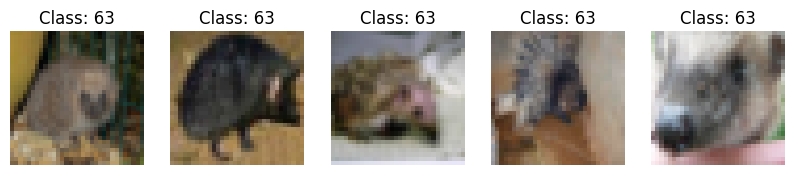

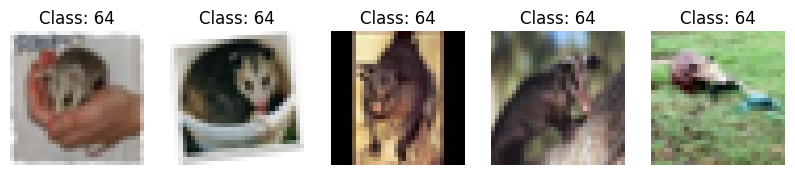

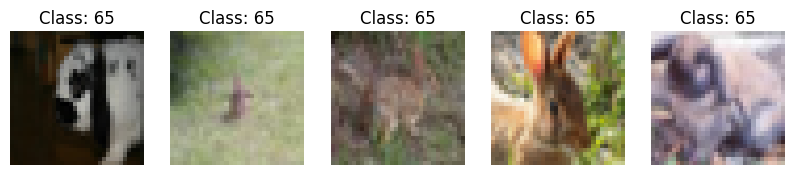

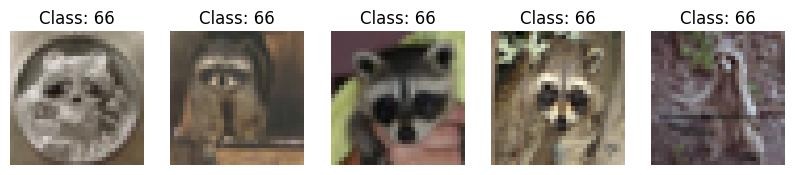

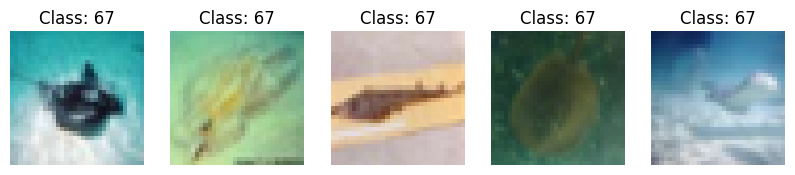

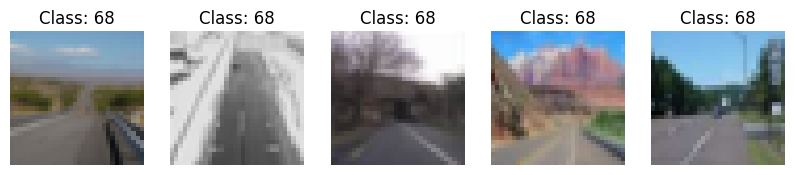

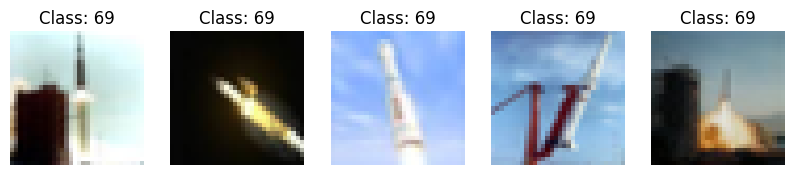

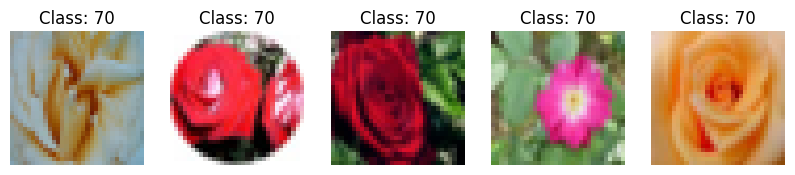

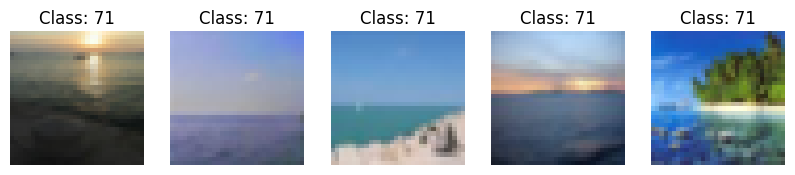

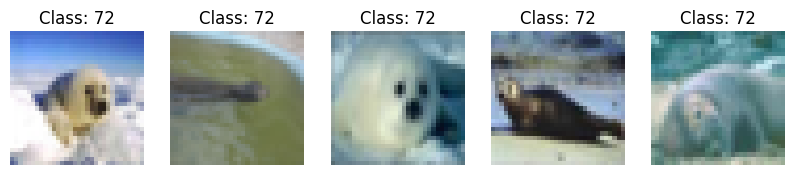

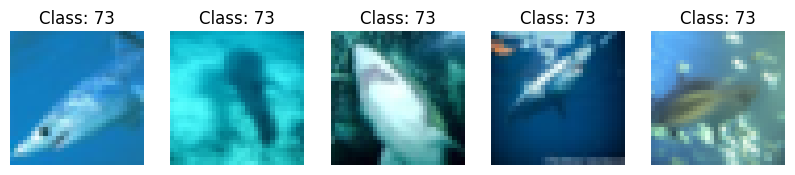

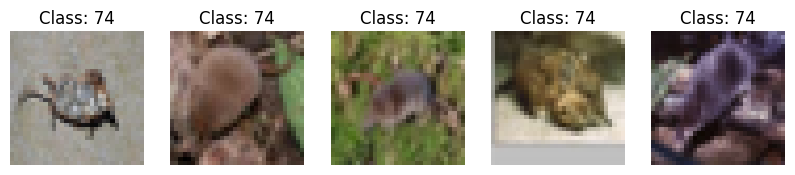

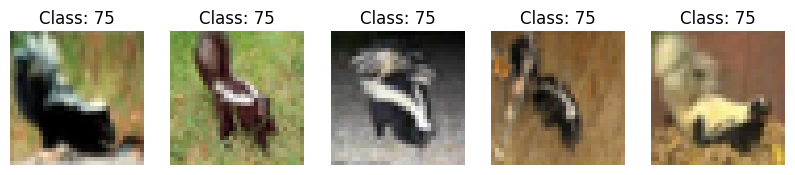

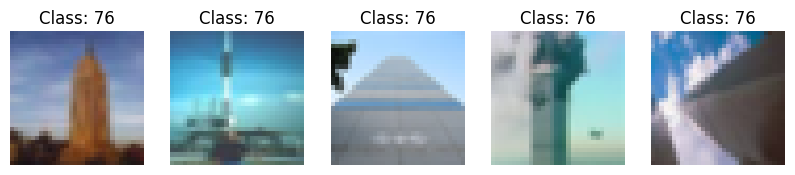

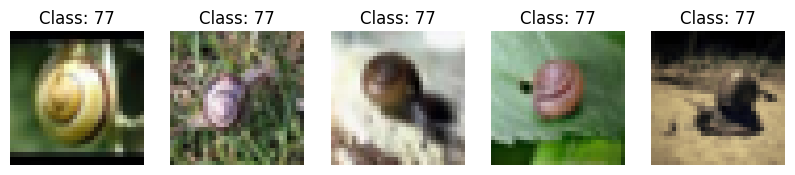

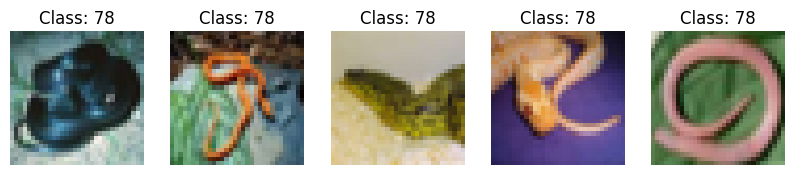

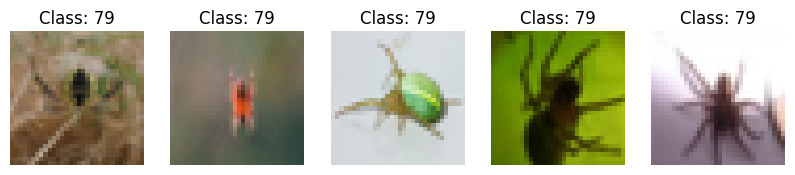

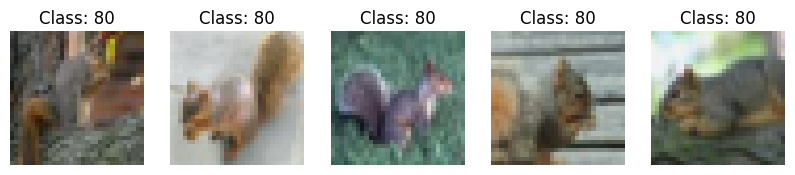

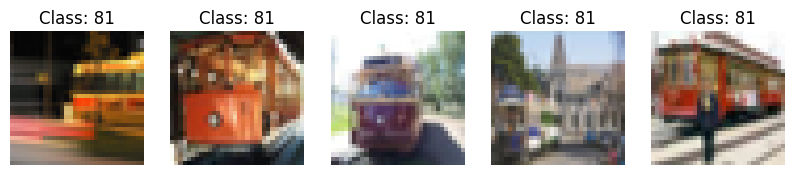

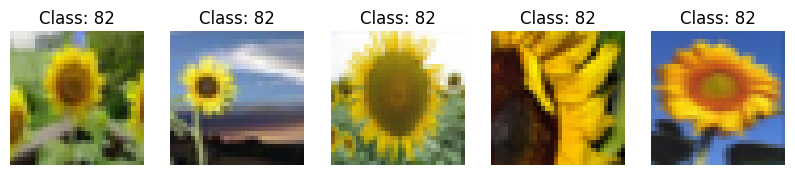

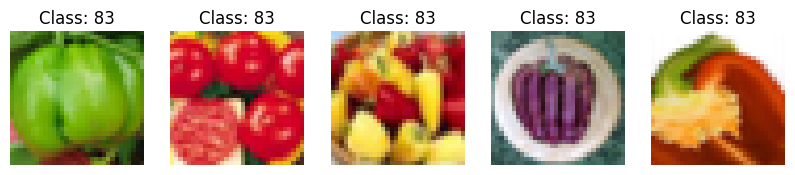

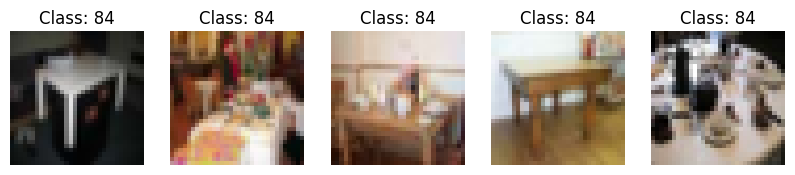

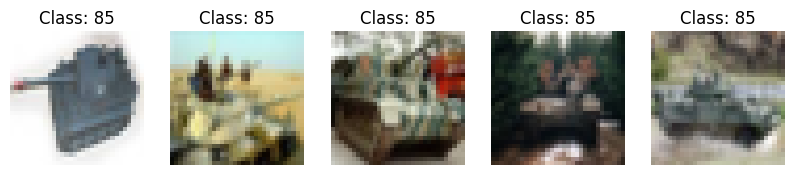

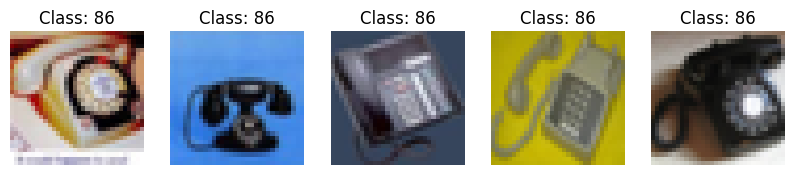

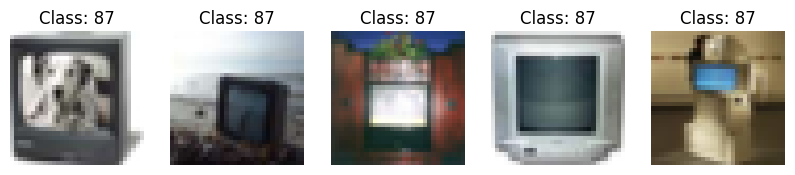

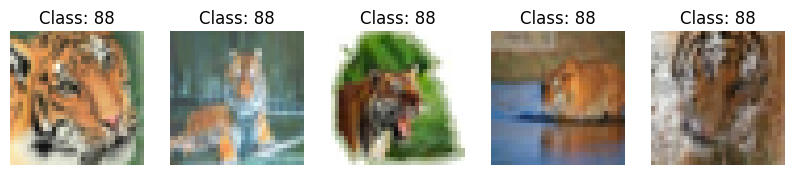

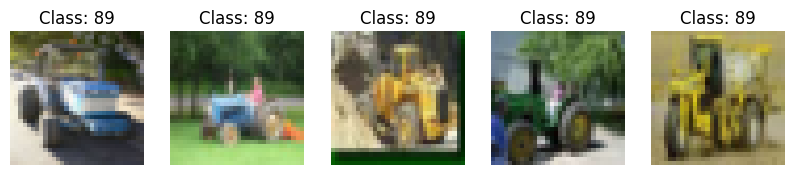

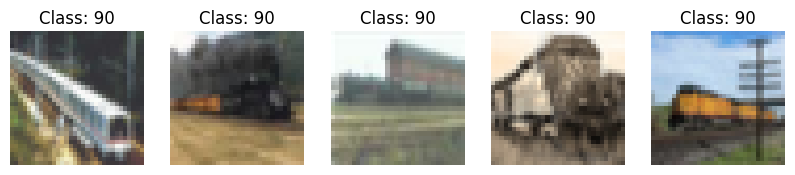

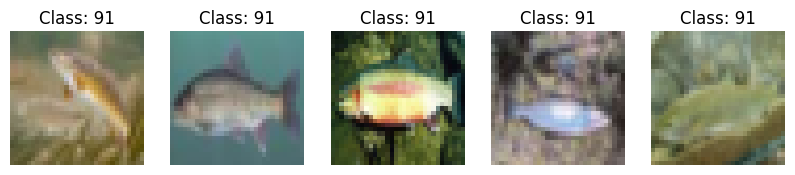

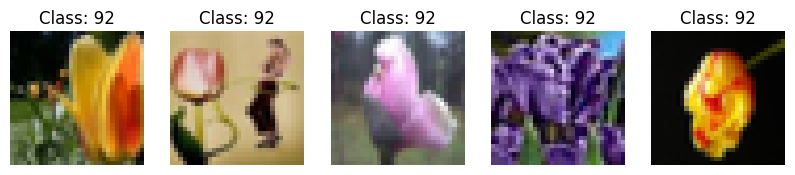

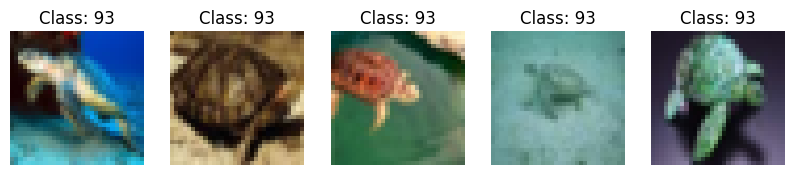

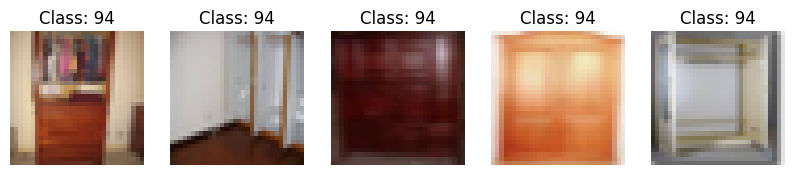

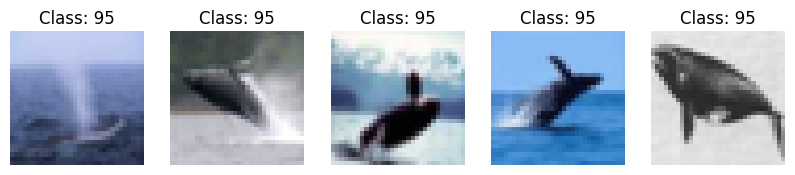

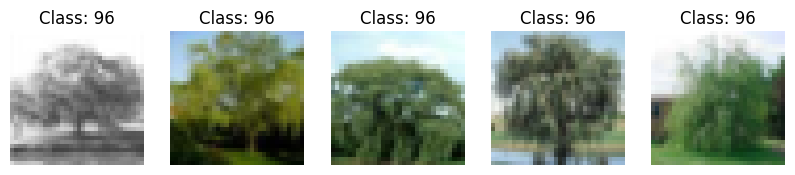

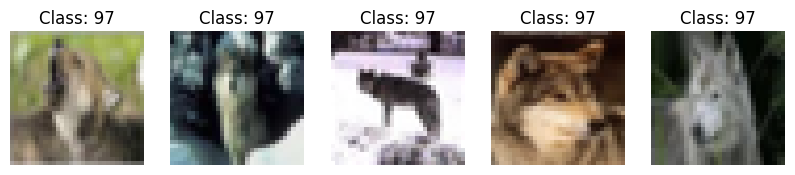

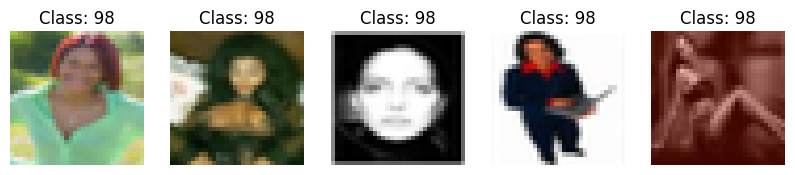

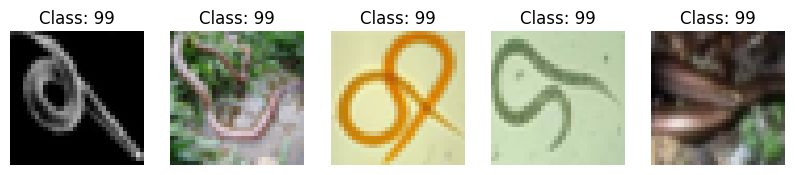

In [ ]:
def plot_class_images(images, labels, class_id, num_images=5):
    class_indices = np.where(labels == class_id)[0]
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(class_indices[:num_images]):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Class: {class_id}")
        plt.axis("off")
    plt.show()

for i in range(100):
    plot_class_images(x_train, y_train, class_id=i)


# MLP experiment

## Hyperparameter tunning with bayesian search

In [ ]:
!pip install scikit-optimize

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from tensorflow.keras.datasets import cifar100
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, 100)
y_val = to_categorical(y_val, 100)
y_test = to_categorical(y_test, 100)

search_space = [
    Integer(1, 6, name='num_layers'),
    Integer(64, 1024, prior='uniform', name='num_units'),
    Categorical(['relu', 'tanh', 'sigmoid'], name='activation'),
    Real(1e-4, 1e-2, 'log-uniform', name='learning_rate'),
    Integer(128, 256, name='batch_size')
]

@use_named_args(search_space)
def objective(num_layers, num_units, activation, learning_rate, batch_size):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(32, 32, 3)))
    for _ in range(num_layers):
        model.add(keras.layers.Dense(num_units, activation=activation))
    model.add(keras.layers.Dense(100, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=5,
        batch_size=batch_size,
        verbose=0
    )

    val_acc = history.history['val_accuracy'][-1]
    return -val_acc

result = gp_minimize(objective, search_space, n_calls=15, random_state=42)

best_hyperparams = {
    "num_layers": result.x[0],
    "num_units": result.x[1],
    "activation": result.x[2],
    "learning_rate": result.x[3],
    "batch_size": result.x[4]
}

print("Best hyperparameters:", best_hyperparams)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `inpu

Best hyperparameters: {'num_layers': np.int64(3), 'num_units': np.int64(805), 'activation': np.str_('relu'), 'learning_rate': 0.00039306003576788977, 'batch_size': np.int64(149)}


## Training a model with the best hyperparameters founded

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

best_hyperparams = {
    "num_layers": 3,
    "num_units": 805,
    "activation": "relu",
    "learning_rate": 0.00039306003576788977,
    "batch_size": 149
}

model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(32, 32, 3)))
for _ in range(best_hyperparams["num_layers"]):
    model.add(keras.layers.Dense(best_hyperparams["num_units"], activation=best_hyperparams["activation"]))
model.add(keras.layers.Dense(100, activation='softmax'))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_hyperparams["learning_rate"]),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=best_hyperparams["batch_size"],
    verbose=1
)



Epoch 1/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0555 - loss: 4.2642 - val_accuracy: 0.1359 - val_loss: 3.7245
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1438 - loss: 3.6458 - val_accuracy: 0.1661 - val_loss: 3.5623
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1781 - loss: 3.4548 - val_accuracy: 0.1878 - val_loss: 3.4499
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2043 - loss: 3.3035 - val_accuracy: 0.2056 - val_loss: 3.3394
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2318 - loss: 3.1672 - val_accuracy: 0.2154 - val_loss: 3.2823
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2454 - loss: 3.0661 - val_accuracy: 0.2283 - val_loss: 3.2392
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2666 - loss: 2.9631 - val_accuracy: 0.2409 - val_loss: 3.1836
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2898 - loss: 2.8504 - val_accuracy: 0.

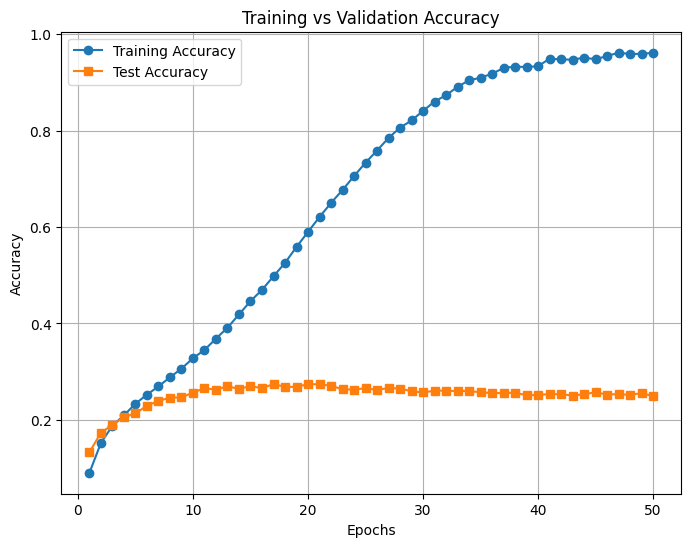

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(train_acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# CNN experiment

## Hyperparameter tunning with bayesian search

In [ ]:
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, 100)
y_val = to_categorical(y_val, 100)
y_test = to_categorical(y_test, 100)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

def build_model(hp):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        padding='same',
        activation='relu',
        input_shape=(32, 32, 3)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        padding='same',
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))

    # Block 2
    model.add(layers.Conv2D(
        filters=hp.Int('conv3_filters', min_value=64, max_value=256, step=64),
        kernel_size=(3, 3),
        padding='same',
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(
        filters=hp.Int('conv4_filters', min_value=64, max_value=256, step=64),
        kernel_size=(3, 3),
        padding='same',
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(hp.Float('dropout2', 0.3, 0.5, step=0.1)))

    # Block 3
    model.add(layers.Conv2D(
        filters=hp.Int('conv5_filters', min_value=128, max_value=512, step=128),
        kernel_size=(3, 3),
        padding='same',
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(
        filters=hp.Int('conv6_filters', min_value=128, max_value=512, step=128),
        kernel_size=(3, 3),
        padding='same',
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(hp.Float('dropout3', 0.3, 0.5, step=0.1)))

    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=256, max_value=1024, step=256),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Float('dropout_dense', 0.4, 0.6, step=0.1)))
    model.add(layers.Dense(100, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='cifar100_tuning',
    project_name='bayesian_cnn'
)

tuner.search(datagen.flow(x_train, y_train, batch_size=128),
             epochs=20,
             validation_data=(x_val, y_val))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters:
- Conv1 Filters: {best_hps.get('conv1_filters')}
- Conv2 Filters: {best_hps.get('conv2_filters')}
- Conv3 Filters: {best_hps.get('conv3_filters')}
- Conv4 Filters: {best_hps.get('conv4_filters')}
- Conv5 Filters: {best_hps.get('conv5_filters')}
- Conv6 Filters: {best_hps.get('conv6_filters')}
- Dense Units: {best_hps.get('dense_units')}
- Dropout 1: {best_hps.get('dropout1')}
- Dropout 2: {best_hps.get('dropout2')}
- Dropout 3: {best_hps.get('dropout3')}
- Dropout Dense: {best_hps.get('dropout_dense')}
- Learning Rate: {best_hps.get('learning_rate')}
""")



Trial 10 Complete [00h 10m 35s]
val_accuracy: 0.4465000033378601

Best val_accuracy So Far: 0.5896999835968018
Total elapsed time: 01h 39m 16s

Best hyperparameters:
- Conv1 Filters: 64
- Conv2 Filters: 96
- Conv3 Filters: 256
- Conv4 Filters: 256
- Conv5 Filters: 384
- Conv6 Filters: 256
- Dense Units: 512
- Dropout 1: 0.2
- Dropout 2: 0.4
- Dropout 3: 0.3
- Dropout Dense: 0.5
- Learning Rate: 0.0012850734177059751



## Training a model with the best hyperparameters founded

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)


datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

conv1_filters = 64
conv2_filters = 96
conv3_filters = 256
conv4_filters = 256
conv5_filters = 384
conv6_filters = 256
dense_units = 512
dropout1 = 0.2
dropout2 = 0.4
dropout3 = 0.3
dropout_dense = 0.5
learning_rate = 0.0012850734177059751

def build_best_model():
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(conv1_filters, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(conv2_filters, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(dropout1))

    # Block 2
    model.add(layers.Conv2D(conv3_filters, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(conv4_filters, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(dropout2))

    # Block 3
    model.add(layers.Conv2D(conv5_filters, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(conv6_filters, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(dropout3))

    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout_dense))
    model.add(layers.Dense(100, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Train the best model
best_model = build_best_model()
history = best_model.fit(datagen.flow(x_train, y_train, batch_size=128),
                         epochs=100,
                         validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 54s 111ms/step - accuracy: 0.0677 - loss: 4.2306 - val_accuracy: 0.0219 - val_loss: 6.3379
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - accuracy: 0.1851 - loss: 3.3266 - val_accuracy: 0.2772 - val_loss: 2.8500
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 92ms/step - accuracy: 0.2795 - loss: 2.8008 - val_accuracy: 0.2471 - val_loss: 3.0101
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.3564 - loss: 2.4475 - val_accuracy: 0.4137 - val_loss: 2.2152
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/step - accuracy: 0.4092 - loss: 2.1903 - val_accuracy: 0.4151 - val_loss: 2.2283
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 92ms/step - accuracy: 0.4488 - loss: 2.0188 - val_accuracy: 0.3858 - val_loss: 2.4983
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - accuracy: 0.4805 - loss: 1.8941 - val_accuracy: 0.5107 - val_loss: 1.7771
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.5119 - loss: 

## CNN Topology used for the experiment

In [ ]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 256)         │         221,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,475,598 (32.33 MB)

 Trainable params: 2,824,324 (10.77 MB)

 Non-trainable params: 2,624 (10.25 KB)

 Optimizer params: 5,648,650 (21.55 MB)

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(train_acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
